In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import cv2

environment = gym.make("MountainCar-v0")


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:

class Network(nn.Module):
    def __init__(self, state_dimension, action_dimension):
        super(Network, self).__init__()
        self.input_layer = nn.Linear(state_dimension, 128)
        self.hidden_layer = nn.Linear(128, 128)
        self.output_layer = nn.Linear(128, action_dimension)

    def forward(self, state):
        state = torch.relu(self.input_layer(state))
        state = torch.relu(self.hidden_layer(state))
        return self.output_layer(state)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

state_dimension = environment.observation_space.shape[0]
action_dimension = environment.action_space.n
policy_network = Network(state_dimension, action_dimension)
target_network = Network(state_dimension, action_dimension)
target_network.load_state_dict(policy_network.state_dict())
target_network.eval()

optimizer = optim.Adam(policy_network.parameters(), lr=0.001)
memory = deque(maxlen=10000)


In [ ]:

def choose(state, exploration_rate):
    if random.random() < exploration_rate:
        return environment.action_space.sample()
    else:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        action_values = policy_network(state_tensor)
        return torch.argmax(action_values).item()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def update():
    if len(memory) < 64:
        return

    batch = random.sample(memory, 64)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions).unsqueeze(1)
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(next_states)
    dones = torch.FloatTensor(dones)

    q_values = policy_network(states).gather(1, actions).squeeze()

    with torch.no_grad():
        max_next_q_values = target_network(next_states).max(1)[0]
        target_q_values = rewards + 0.99 * max_next_q_values * (1 - dones)

    loss = nn.MSELoss()(q_values, target_q_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [ ]:

rewards_per_episode = []
step_counter = 0
exploration_rate = 1.0

for episode in range(500):
    state = environment.reset()
    episode_reward = 0
    done = False

    while not done:

        action = choose(state, exploration_rate)
        next_state, reward, done, _ = environment.step(action)

        if done and next_state[0] >= 0.5:
            reward = 1.0

        #
        memory.append((state, action, reward, next_state, done))

        state = next_state
        episode_reward += reward

        update()

        if step_counter % 100 == 0:
            target_network.load_state_dict(policy_network.state_dict())

        step_counter += 1

    exploration_rate = max(0.01, exploration_rate * 0.995)

    rewards_per_episode.append(episode_reward)

    if (episode + 1) % 10 == 0:
        print(f"Episode {episode + 1}: Reward = {episode_reward}")


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-5-2074e525cc16>:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor(states)


Episode 10: Reward = -200.0
Episode 20: Reward = -200.0
Episode 30: Reward = -200.0
Episode 40: Reward = -200.0
Episode 50: Reward = -200.0
Episode 60: Reward = -200.0
Episode 70: Reward = -200.0
Episode 80: Reward = -200.0
Episode 90: Reward = -200.0
Episode 100: Reward = -200.0
Episode 110: Reward = -200.0
Episode 120: Reward = -200.0
Episode 130: Reward = -200.0
Episode 140: Reward = -200.0
Episode 150: Reward = -200.0
Episode 160: Reward = -200.0
Episode 170: Reward = -200.0
Episode 180: Reward = -200.0
Episode 190: Reward = -200.0
Episode 200: Reward = -200.0
Episode 210: Reward = -200.0
Episode 220: Reward = -200.0
Episode 230: Reward = -200.0
Episode 240: Reward = -200.0
Episode 250: Reward = -200.0
Episode 260: Reward = -154.0
Episode 270: Reward = -200.0
Episode 280: Reward = -146.0
Episode 290: Reward = -158.0
Episode 300: Reward = -200.0
Episode 310: Reward = -176.0
Episode 320: Reward = -167.0
Episode 330: Reward = -155.0
Episode 340: Reward = -148.0
Episode 350: Reward = -

Model saved.


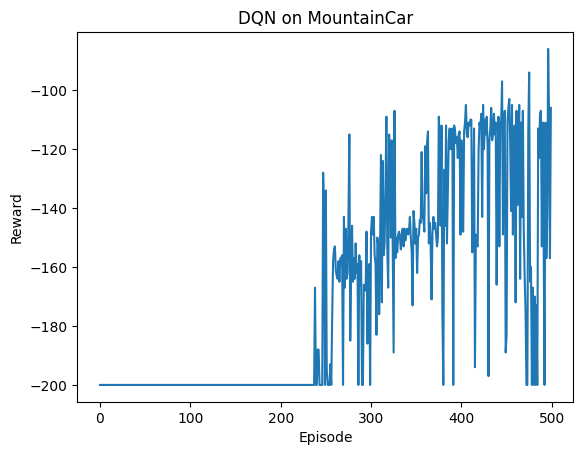

In [ ]:

torch.save(policy_network.state_dict(), "dqn_mountaincar.pth")
print("Model saved.")

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN on MountainCar')
plt.show()


In [ ]:

def record(environment, trained_network, filename="mountaincar_gameplay.mp4"):
    frames = []
    state = environment.reset()
    done = False
    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        action = torch.argmax(trained_network(state_tensor)).item()
        next_state, _, done, _ = environment.step(action)

        frame = environment.render(mode='rgb_array')
        frames.append(frame)
        state = next_state

    #
    height, width, layers = frames[0].shape
    video_writer = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))
    for frame in frames:
        video_writer.write(frame)
    video_writer.release()


In [ ]:

record(environment, policy_network)



Recording gameplay video...


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning

Video saved.
